# Trackwerte um Trackpunkt suchen

In diesem Notebook laden wir uns die autmatischen Tracks und suchen uns die Werte um den Trackpunkt.


In [1]:
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

from analysis_tools import grid_and_interpolation as gi
import xarray as xr
import glob

from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2()

import h5py

import sys
sys.path.append("/vols/talos/home/stephan/utils/tracking")
import tracking_common as tco
import cross_correlation_tracking as cct

from skimage.feature import register_translation

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [68]:
#track_path = "/vols/talos/home/stephan/data/radar_track/analyse_tracks/"
track_path= "/vols/talos/home/stephan/data/radar_track/manuell/"
trackdatenverzeichnis = "/vols/talos/home/stephan/data/radar_track/trackdata/"

base_fields = ['ir','hrv']
tracking_methods = ['man','xcorr','fb','tvl1']
field_name = {'ir':u'IR 10.8µm', 'hrv':'HRV'}
method_name = {'man':'visual',
               'xcor':'cross corr.',
               'fb':u'Farnebäck',
               'tvl1':'TV-L1'}

In [3]:
tracks = glob.glob("{}*.h5".format(track_path))

In [4]:
def get_neighbourhood(row,col,size,row_max,col_max):
    row_min = np.clip(row-size//2,0,row_max)
    row_max = np.clip(row+size//2+1,0,row_max)
    col_min = np.clip(col-size//2,0,col_max)
    col_max = np.clip(col+size//2+1,0,col_max)
    
    return int(row_min), int(row_max), int(col_min), int(col_max)

In [5]:
r_size_ir = 6
c_size_ir = 3
r_size_hrv = 2
c_size_hrv = 1

In [35]:
tr  =tracks[0]

In [36]:
with h5py.File(tr,'r') as f:
        col_idx = f['col_index'][:]
        row_idx = f['row_index'][:]
        time = f['time'][:]

In [37]:
col_idx, row_idx

(array([28.34943182, 27.85267857, 27.90787338, 27.52150974, 27.19034091,
        27.24553571, 26.69358766, 24.20982143, 24.65137987, 23.38189935,
        21.72605519, 22.05291842]),
 array([23.89935065, 24.17532468, 23.45779221, 23.4025974 , 23.51298701,
        22.57467532, 21.58116883, 24.06493506, 22.96103896, 23.45779221,
        23.12662338, 22.49209062]))

In [40]:
col_idx = np.insert(col_idx,-1,21.6)

In [41]:
row_idx = np.insert(row_idx,-1,22.6)

In [45]:
time = np.insert(time,-1,1535)

In [43]:
len(row_idx)

13

In [46]:
oid = "%s_%s" % (tr.split("/")[-1].split(".")[0].split("_")[-2],
                         tr.split("/")[-1].split(".")[0].split("_")[-1])

trackdata = xr.open_dataset(trackdatenverzeichnis + "/haci_trackdata_%s.nc" % oid)

track_points = pd.DataFrame({'row_idx':row_idx,'col_idx':col_idx,'time':[t.split(".")[0] for t in time]})

start_index = (6, track_points.row_idx.iloc[6],track_points.col_idx.iloc[6])
start_index_hrv = (6, track_points.row_idx.iloc[6]*3,track_points.col_idx.iloc[6]*3)

fb_track_ir = tco.calculate_track(trackdata.ir108.data,start_index,'farnebaeck',51)
fb_track_hrv = tco.calculate_track(trackdata.hrv.data,start_index_hrv,'farnebaeck',51*3)

cc_track_ir = tco.calculate_track(trackdata.ir108.data,start_index,'xcorr',51)
cc_track_hrv = tco.calculate_track(trackdata.hrv.data,start_index_hrv,'xcorr',51*3)

tvl1_track_ir = tco.calculate_track(trackdata.ir108.data,start_index,'tvl1',51)
tvl1_track_hrv = tco.calculate_track(trackdata.hrv.data,start_index_hrv,'tvl1',51*3)

In [53]:
save_path = "/vols/talos/home/stephan/data/radar_track/automatic_tracks"
file_name = "{}/track_{}.csv".format(save_path,oid)

trackpunkte.to_csv(file_name,index=False,float_format="%.3f")

# Trackingfehler
cc_ee_ir = []
fb_ee_ir = []
tvl1_ee_ir = []
cc_ee_hrv = []
fb_ee_hrv = []
tvl1_ee_hrv = []

for i, r in cc_track_ir.iterrows():
    cc_ee_ir.append(tco.calc_end_point_error(r.row_index,r.column_index,
                                             row_idx[i],
                                             col_idx[i],r_size_ir,c_size_ir))
    fb_ee_ir.append(tco.calc_end_point_error(fb_track_ir.row_index.iloc[i],
                                             fb_track_ir.column_index.iloc[i],
                                             row_idx[i],
                                             col_idx[i],r_size_ir,c_size_ir))
    tvl1_ee_ir.append(tco.calc_end_point_error(tvl1_track_ir.row_index.iloc[i],
                                               tvl1_track_ir.column_index.iloc[i],
                                               row_idx[i],
                                               col_idx[i],r_size_ir,c_size_ir))

    cc_ee_hrv.append(tco.calc_end_point_error(r.row_index,r.column_index,
                                              row_idx[i]*3,
                                              col_idx[i]*3,r_size_hrv,c_size_hrv))
    fb_ee_hrv.append(tco.calc_end_point_error(fb_track_hrv.row_index.iloc[i],
                                              fb_track_hrv.column_index.iloc[i],
                                              row_idx[i]*3,
                                              col_idx[i]*3,r_size_hrv,c_size_hrv))
    tvl1_ee_hrv.append(tco.calc_end_point_error(tvl1_track_hrv.row_index.iloc[i]*3,
                                                tvl1_track_hrv.column_index.iloc[i]*3,
                                                row_idx[i],
                                                col_idx[i],r_size_hrv,c_size_hrv))



In [59]:
end_point_error = pd.DataFrame({'xcorr_ir':cc_ee_ir,
                                'farnebaeck_ir':fb_ee_ir,
                                'tvl1_ir': tvl1_ee_ir,
                                'xcorr_hrv':cc_ee_hrv,
                                'farnebaeck_hrv':fb_ee_hrv,
                                'tvl1_hrv': tvl1_ee_hrv,
                                'time': time,
                                'tidx':np.arange(-30,len(time)//2*5+5,5)})

end_point_error.farnebaeck_ir.iloc[6] = 0
end_point_error.tvl1_ir.iloc[6] = 0
end_point_error.xcorr_ir.iloc[6] = 0
end_point_error.farnebaeck_hrv.iloc[6] = 0
end_point_error.tvl1_hrv.iloc[6] = 0
end_point_error.xcorr_hrv.iloc[6] = 0

save_path = "/vols/talos/home/stephan/data/radar_track/track_errors"
file_name = "{}/ee_{}.csv".format(save_path,oid)
end_point_error.to_csv(file_name,index=False,float_format="%.3f")


/home/lenk/.local/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [58]:
np.arange(-30,len(time)//2*5+5,5)

array([-30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,  25,  30])

In [61]:
trackpunkte.keys()

Index([u'column_index_fb_hrv', u'column_index_fb_ir', u'column_index_man',
       u'column_index_tvl1_hrv', u'column_index_tvl1_ir',
       u'column_index_xcorr_hrv', u'column_index_xcorr_ir',
       u'row_index_fb_hrv', u'row_index_fb_ir', u'row_index_man',
       u'row_index_tvl1_hrv', u'row_index_tvl1_ir', u'row_index_xcorr_hrv',
       u'row_index_xcorr_ir'],
      dtype='object')

In [80]:

# Trackwerte
values = {'man_ir_min':[],
          'man_ir_max':[],
          'man_ir_q25':[],
          'man_ir_q75':[],
          'man_ir_med':[],
          'man_hrv_min':[],
          'man_hrv_max':[],
          'man_hrv_q25':[],
          'man_hrv_q75':[],
          'man_hrv_med':[],
          'xcorr_ir_min':[],
          'xcorr_ir_max':[],
          'xcorr_ir_q25':[],
          'xcorr_ir_q75':[],
          'xcorr_ir_med':[],
          'xcorr_hrv_min':[],
          'xcorr_hrv_max':[],
          'xcorr_hrv_q25':[],
          'xcorr_hrv_q75':[],
          'xcorr_hrv_med':[],
          'fb_ir_min':[],
          'fb_ir_max':[],
          'fb_ir_q25':[],
          'fb_ir_q75':[],
          'fb_ir_med':[],
          'fb_hrv_min':[],
          'fb_hrv_max':[],
          'fb_hrv_q25':[],
          'fb_hrv_q75':[],
          'fb_hrv_med':[],
          'tvl1_ir_min':[],
          'tvl1_ir_max':[],
          'tvl1_ir_q25':[],
          'tvl1_ir_q75':[],
          'tvl1_ir_med':[],
          'tvl1_hrv_min':[],
          'tvl1_hrv_max':[],
          'tvl1_hrv_q25':[],
          'tvl1_hrv_q75':[],
          'tvl1_hrv_med':[]}
for bf in base_fields:
    for tm in tracking_methods:
        if bf =='hrv':
            fac = 3
        else:
            fac = 1
        if tm=='man':
            track_rows = trackpunkte['row_index_{}'.format(tm,bf)].values
            track_cols = trackpunkte['column_index_{}'.format(tm,bf)].values
        else:
            track_rows = trackpunkte['row_index_{}_{}'.format(tm,bf)].values
            track_cols = trackpunkte['column_index_{}_{}'.format(tm,bf)].values

        for i, r in enumerate(track_rows):
            if np.isnan(r) and np.isnan(track_cols[i]):
                values['{}_ir'.format(tm)].append(np.nan)
                values['{}_hrv'.format(tm)].append(np.nan)
            else:
                rmn,rmx,cmn,cmx = get_neighbourhood(np.rint(int(r)),
                                                    np.rint(int(track_cols[i])),3*fac,51*fac,51*fac)
                if bf == 'hrv':
                    data = trackdata.hrv.data[i]
                else:
                    data = trackdata.ir108.data[i]

                v = data[rmn:rmx,cmn:cmx]
                values['{}_{}_min'.format(tm,bf)].append(np.nanmin(v))
                values['{}_{}_med'.format(tm,bf)].append(np.nanmedian(v))
                values['{}_{}_max'.format(tm,bf)].append(np.nanmax(v))
                values['{}_{}_q25'.format(tm,bf)].append(np.nanpercentile(v,25))
                values['{}_{}_q75'.format(tm,bf)].append(np.nanpercentile(v,75)) 

value_df = pd.DataFrame(values) 

save_path = "/vols/talos/home/stephan/data/radar_track/track_values"
file_name = "{}/values_{}.csv".format(save_path,oid)


value_df.to_csv(file_name,index=False,float_format="%.3f")

In [78]:
r  = track_rows[0]
c  =track_cols[0]

In [82]:
for tr in tracks[1:]:
    with h5py.File(tr,'r') as f:
        col_idx = f['col_index'][:]
        row_idx = f['row_index'][:]
        time = f['time'][:]
    
    oid = "%s_%s" % (tr.split("/")[-1].split(".")[0].split("_")[-2],
                             tr.split("/")[-1].split(".")[0].split("_")[-1])
    
    trackdata = xr.open_dataset(trackdatenverzeichnis + "/haci_trackdata_%s.nc" % oid)
    
    track_points = pd.DataFrame({'row_idx':row_idx,'col_idx':col_idx,'time':[t.split(".")[0] for t in time]})
    
    start_index = (6, track_points.row_idx.iloc[6],track_points.col_idx.iloc[6])
    start_index_hrv = (6, track_points.row_idx.iloc[6]*3,track_points.col_idx.iloc[6]*3)
    
    fb_track_ir = tco.calculate_track(trackdata.ir108.data,start_index,'farnebaeck',51)
    fb_track_hrv = tco.calculate_track(trackdata.hrv.data,start_index_hrv,'farnebaeck',51*3)
    
    cc_track_ir = tco.calculate_track(trackdata.ir108.data,start_index,'xcorr',51)
    cc_track_hrv = tco.calculate_track(trackdata.hrv.data,start_index_hrv,'xcorr',51*3)
    
    tvl1_track_ir = tco.calculate_track(trackdata.ir108.data,start_index,'tvl1',51)
    tvl1_track_hrv = tco.calculate_track(trackdata.hrv.data,start_index_hrv,'tvl1',51*3)
    
    # Trackpunkte speichern
    trackpunkte = pd.DataFrame({#'row_index_man':track_points.row_idx.values,
                               #'column_index_man':track_points.col_idx.values,
                               'row_index_xcorr_ir':cc_track_ir.row_index.values,
                               'column_index_xcorr_ir':cc_track_ir.column_index.values,
                               'row_index_xcorr_hrv':cc_track_hrv.row_index.values,
                               'column_index_xcorr_hrv':cc_track_hrv.column_index.values,
                               'row_index_fb_ir':fb_track_ir.row_index.values,
                               'column_index_fb_ir':fb_track_ir.column_index.values,
                               'row_index_fb_hrv':fb_track_hrv.row_index.values,
                               'column_index_fb_hrv':fb_track_hrv.column_index.values,
                               'row_index_tvl1_ir':tvl1_track_ir.row_index.values,
                               'column_index_tvl1_ir':tvl1_track_ir.column_index.values,
                               'row_index_tvl1_hrv':tvl1_track_hrv.row_index.values,
                               'column_index_tvl1_hrv':tvl1_track_hrv.column_index.values})
    
    save_path = "/vols/talos/home/stephan/data/radar_track/automatic_tracks"
    file_name = "{}/track_{}.csv".format(save_path,oid)
    
    trackpunkte.to_csv(file_name,index=False,float_format="%.3f")
    
    # Trackingfehler
    cc_ee_ir = []
    fb_ee_ir = []
    tvl1_ee_ir = []
    cc_ee_hrv = []
    fb_ee_hrv = []
    tvl1_ee_hrv = []

    for i, r in cc_track_ir.iterrows():
        cc_ee_ir.append(tco.calc_end_point_error(r.row_index,r.column_index,
                                                 track_points.row_idx[i],
                                                 track_points.col_idx[i],r_size_ir,c_size_ir))
        fb_ee_ir.append(tco.calc_end_point_error(fb_track_ir.row_index.iloc[i],
                                                 fb_track_ir.column_index.iloc[i],
                                                 track_points.row_idx[i],
                                                 track_points.col_idx[i],r_size_ir,c_size_ir))
        tvl1_ee_ir.append(tco.calc_end_point_error(tvl1_track_ir.row_index.iloc[i],
                                                   tvl1_track_ir.column_index.iloc[i],
                                                   track_points.row_idx[i],
                                                   track_points.col_idx[i],r_size_ir,c_size_ir))
        
        cc_ee_hrv.append(tco.calc_end_point_error(r.row_index,r.column_index,
                                                  track_points.row_idx[i]*3,
                                                  track_points.col_idx[i]*3,r_size_hrv,c_size_hrv))
        fb_ee_hrv.append(tco.calc_end_point_error(fb_track_hrv.row_index.iloc[i],
                                                  fb_track_hrv.column_index.iloc[i],
                                                  track_points.row_idx[i]*3,
                                                  track_points.col_idx[i]*3,r_size_hrv,c_size_hrv))
        tvl1_ee_hrv.append(tco.calc_end_point_error(tvl1_track_hrv.row_index.iloc[i]*3,
                                                    tvl1_track_hrv.column_index.iloc[i]*3,
                                                    track_points.row_idx[i],
                                                    track_points.col_idx[i],r_size_hrv,c_size_hrv))
        
        end_point_error = pd.DataFrame({'xcorr_ir':cc_ee_ir,
                                        'farnebaeck_ir':fb_ee_ir,
                                        'tvl1_ir': tvl1_ee_ir,
                                        'xcorr_hrv':cc_ee_hrv,
                                        'farnebaeck_hrv':fb_ee_hrv,
                                        'tvl1_hrv': tvl1_ee_hrv,
                                        'time': track_points.time,
                                        'tidx':np.arange(-30,len(track_points.time)//2*5,5)})
        
        end_point_error.farnebaeck_ir.iloc[6] = 0
        end_point_error.tvl1_ir.iloc[6] = 0
        end_point_error.xcorr_ir.iloc[6] = 0
        end_point_error.farnebaeck_hrv.iloc[6] = 0
        end_point_error.tvl1_hrv.iloc[6] = 0
        end_point_error.xcorr_hrv.iloc[6] = 0
        
        save_path = "/vols/talos/home/stephan/data/radar_track/track_errors"
        file_name = "{}/ee_{}.csv".format(save_path,oid)
        end_point_error.to_csv(file_name,index=False,float_format="%.3f")
          
        # Trackwerte
        values = {'man_ir_min':[],
                  'man_ir_max':[],
                  'man_ir_q25':[],
                  'man_ir_q75':[],
                  'man_ir_med':[],
                  'man_hrv_min':[],
                  'man_hrv_max':[],
                  'man_hrv_q25':[],
                  'man_hrv_q75':[],
                  'man_hrv_med':[],
                  'xcorr_ir_min':[],
                  'xcorr_ir_max':[],
                  'xcorr_ir_q25':[],
                  'xcorr_ir_q75':[],
                  'xcorr_ir_med':[],
                  'xcorr_hrv_min':[],
                  'xcorr_hrv_max':[],
                  'xcorr_hrv_q25':[],
                  'xcorr_hrv_q75':[],
                  'xcorr_hrv_med':[],
                  'fb_ir_min':[],
                  'fb_ir_max':[],
                  'fb_ir_q25':[],
                  'fb_ir_q75':[],
                  'fb_ir_med':[],
                  'fb_hrv_min':[],
                  'fb_hrv_max':[],
                  'fb_hrv_q25':[],
                  'fb_hrv_q75':[],
                  'fb_hrv_med':[],
                  'tvl1_ir_min':[],
                  'tvl1_ir_max':[],
                  'tvl1_ir_q25':[],
                  'tvl1_ir_q75':[],
                  'tvl1_ir_med':[],
                  'tvl1_hrv_min':[],
                  'tvl1_hrv_max':[],
                  'tvl1_hrv_q25':[],
                  'tvl1_hrv_q75':[],
                  'tvl1_hrv_med':[]}
        for bf in base_fields:
            for tm in tracking_methods:
                if bf =='hrv':
                    fac = 3
                else:
                    fac = 1
                if tm=='man':
                    track_rows = trackpunkte['row_index_{}'.format(tm,bf)].values
                    track_cols = trackpunkte['column_index_{}'.format(tm,bf)].values
                else:
                    track_rows = trackpunkte['row_index_{}_{}'.format(tm,bf)].values
                    track_cols = trackpunkte['column_index_{}_{}'.format(tm,bf)].values

                for i, r in enumerate(track_rows):
                    if np.isnan(r) and np.isnan(track_cols[i]):
                        values['{}_ir'.format(tm)].append(np.nan)
                        values['{}_hrv'.format(tm)].append(np.nan)
                    else:
                        rmn,rmx,cmn,cmx = get_neighbourhood(np.rint(int(r)),
                                                            np.rint(int(track_cols[i])),3*fac,51*fac,51*fac)
                        if bf == 'hrv':
                            data = trackdata.hrv.data[i]
                        else:
                            data = trackdata.ir108.data[i]

                        v = data[rmn:rmx,cmn:cmx]
                        values['{}_{}_min'.format(tm,bf)].append(np.nanmin(v))
                        values['{}_{}_med'.format(tm,bf)].append(np.nanmedian(v))
                        values['{}_{}_max'.format(tm,bf)].append(np.nanmax(v))
                        values['{}_{}_q25'.format(tm,bf)].append(np.nanpercentile(v,25))
                        values['{}_{}_q75'.format(tm,bf)].append(np.nanpercentile(v,75)) 

        value_df = pd.DataFrame(values) 

        save_path = "/vols/talos/home/stephan/data/radar_track/track_values"
        file_name = "{}/values_{}.csv".format(save_path,oid)


        value_df.to_csv(file_name,index=False,float_format="%.3f")

ValueError: arrays must all be same length

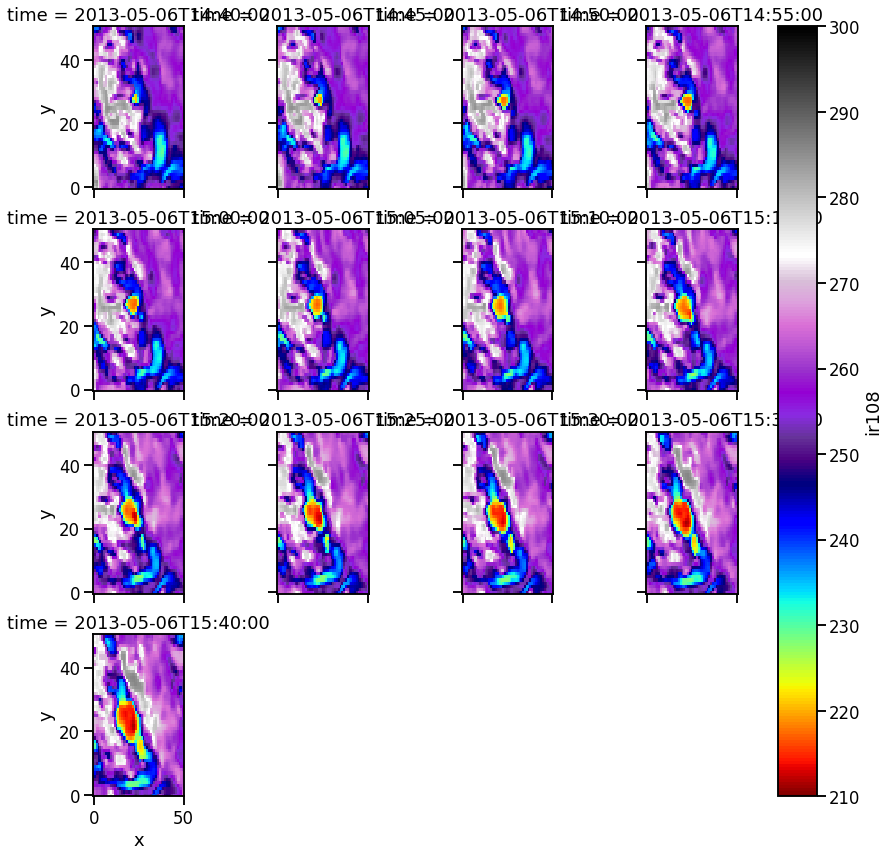

In [10]:
trackdata.ir108.plot(x='x',y='y',col='time',col_wrap=4,vmin=210,vmax=300,cmap=emap)

In [11]:
def get_neighbourhood(row,col,size,row_max,col_max):
    row_min = np.clip(row-size//2,0,row_max)
    row_max = np.clip(row+size//2+1,0,row_max)
    col_min = np.clip(col-size//2,0,col_max)
    col_max = np.clip(col+size//2+1,0,col_max)
    
    return int(row_min), int(row_max), int(col_min), int(col_max)

In [12]:
values = {'ir108':{'min':[],'max':[],'med':[],'q25':[],'q75':[]},
          'hrv':{'min':[],'max':[],'med':[],'q25':[],'q75':[]}}

for i, r in track_points.iterrows():
    if np.isnan(r.row_idx) and np.isnan(r.col_idx):
        values['ir108'].append(np.nan)
        values['hrv'].append(np.nan)
    else:
        rmn,rmx,cmn,cmx = get_neighbourhood(np.rint(int(r.row_idx)),
                                            np.rint(int(r.col_idx)),3,51,51)
        
        v = trackdata.ir108.data[i][rmn:rmx,cmn:cmx]
        values['ir108']['min'].append(np.nanmin(v))
        values['ir108']['med'].append(np.nanmedian(v))
        values['ir108']['max'].append(np.nanmax(v))
        values['ir108']['q25'].append(np.nanpercentile(v,25))
        values['ir108']['q75'].append(np.nanpercentile(v,75))
        
        rmn,rmx,cmn,cmx = get_neighbourhood(np.rint(int(r.row_idx*3)),
                                            np.rint(int(r.col_idx*3)),9,153,153)
        
        v = trackdata.hrv.data[i][rmn:rmx,cmn:cmx]
        values['hrv']['min'].append(np.nanmin(v))
        values['hrv']['med'].append(np.nanmedian(v))
        values['hrv']['max'].append(np.nanmax(v))
        values['hrv']['q25'].append(np.nanpercentile(v,25))
        values['hrv']['q75'].append(np.nanpercentile(v,75))

In [13]:
values

{'hrv': {'max': [0.7183980311919494,
   0.7410717232063133,
   0.6957243391775858,
   0.7422650754175958,
   0.6849841692760449,
   0.531041734020627,
   0.47256747566779395,
   0.7565853019529833,
   0.5596821870914026,
   0.5751957658380725,
   0.7136246223468202,
   0.5895159923734602],
  'med': [0.4427336703857364,
   0.44989378365343025,
   0.44750707923086563,
   0.44989378365343025,
   0.45228048807599475,
   0.4272200916390663,
   0.42005997837137254,
   0.3472654934831517,
   0.3830660598216209,
   0.39141952530059715,
   0.44870043144214794,
   0.3794860031877741],
  'min': [0.18616294496004016,
   0.1455889697764416,
   0.18377624053747552,
   0.15871584410054704,
   0.21002998918568624,
   0.23151032898876778,
   0.3520389023282809,
   0.11933522112823086,
   0.13604215208618314,
   0.10262829017027852,
   0.28043776965134243,
   0.24941061215800242],
  'q25': [0.3412987324267401,
   0.36277907222982175,
   0.3687458332862332,
   0.4069331040472672,
   0.3997729907795732,
 

In [14]:
out_dir = "/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/images4manual/"

for tr in tracks:
    try:
        oid = "%s_%s" % (tr.split("/")[-1].split(".")[0].split("_")[-2],
                                 tr.split("/")[-1].split(".")[0].split("_")[-1])

        out = "{}{}".format(out_dir,oid)
        if not os.path.exists(out):
            os.makedirs(out)

        trackdata = xr.open_dataset(trackdatenverzeichnis + "/haci_trackdata_%s.nc" % oid)

        for i,ir in enumerate(trackdata.ir108.data):
            fig,ax = plt.subplots(1,1,figsize=(51./100,51./100))
            ax.imshow(ir,vmin=210,vmax=300,cmap=emap)
            ax.set_axis_off()
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)
            plt.margins(0,0)
            ax.xaxis.set_major_locator(mpl.ticker.NullLocator())
            ax.yaxis.set_major_locator(mpl.ticker.NullLocator())

            t = pd.Timestamp(trackdata.time.data[i]).strftime("%H%M")
            plt.savefig("{}/{}.png".format(out,t),dpi=100)
            plt.close()
    except:
        continue

<Figure size 36.72x36.72 with 0 Axes>